In [1]:
import json
import requests

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Parameters

In [ ]:
BASE_URL = "https://api.dune.com/api/v1/"

# Set your Dune query ID
query_id = "2646371" #"2646554"


# Set the headers with your Dune API key
API_KEY = "..." # Replace with your own Dune key
HEADER = {"x-dune-api-key" : API_KEY}


# Set the  wallet address to analyse (we are not directly using this here).
# It's hardcoded on Dune but it could be send as parameter as well.

wallet_address = "0x6eA158145907a1fAc74016087611913A96d96624"

# Dune query

I have first created the SQL Dune query to fetch the data on my Dune account.  
You can find it here

https://dune.com/queries/2646371

For your convenience, the query is displayed below. But we will only retrieve the result of the query from Dune API.


In [ ]:


query = """
-- Start by selecting distinct incoming transfer records for the wallet of interest
WITH filtered_transfers AS (
  SELECT DISTINCT t.evt_block_time, t."from", t.contract_address, t.value, t.evt_tx_hash
  FROM erc20_ethereum.evt_Transfer AS t
  WHERE t.to = 0x6eA158145907a1fAc74016087611913A96d96624
)

-- Select distinct transfer records along with additional information
SELECT DISTINCT f.*, p.symbol,

  -- Calculate the raw amount received by dividing the value by the token decimals
  ROUND(f.value  / POW(10, COALESCE(p.decimals, 18)),5) AS raw_amount_received,

  -- Calculate the USD amount received based on the token price
  ROUND((f.value / POW(10, COALESCE(p.decimals, 18))) * CASE WHEN p.symbol = 'USDT' OR p.symbol = 'USDC' THEN 1 ELSE p.price END) AS usd_amount_received

FROM filtered_transfers AS f

-- Left join with the USD price table based on the contract address and block time
LEFT JOIN prices.usd AS p ON p.contract_address = f.contract_address
  AND date_trunc('minute', f.evt_block_time) = date_trunc('minute', p.minute)

  -- Exclude transfers with zero raw amount received
  AND ROUND(f.value  / POW(10, COALESCE(p.decimals, 18)),5) > 0

-- Sort the results by the USD amount received in descending order
ORDER BY usd_amount_received DESC
"""


# Get data from Dune

We need to connect to Dune API and retrieve the result of our query above.   
We need to wait for the execution to finish. And then retrieve the results.


In [24]:
def make_api_url(module, action, ID):
    """
    We shall use this function to generate a URL to call the API.
    """

    url = BASE_URL + module + "/" + ID + "/" + action

    return url

def execute_query(query_id, engine="medium"):
    """
    Takes in the query ID and engine size.
    Specifying the engine size will change how quickly your query runs. 
    The default is "medium" which spends 10 credits, while "large" spends 20 credits.
    Calls the API to execute the query.
    Returns the execution ID of the instance which is executing the query.
    """

    url = make_api_url("query", "execute", query_id)
    params = {
        "performance": engine,
    }
    response = requests.post(url, headers=HEADER, params=params)
    execution_id = response.json()['execution_id']

    return execution_id


def get_query_status(execution_id):
    """
    Takes in an execution ID.
    Fetches the status of query execution using the API
    Returns the status response object
    """

    url = make_api_url("execution", "status", execution_id)
    response = requests.get(url, headers=HEADER)

    return response


def get_query_results(execution_id):
    """
    Takes in an execution ID.
    Fetches the results returned from the query using the API
    Returns the results response object
    """

    url = make_api_url("execution", "results", execution_id)
    response = requests.get(url, headers=HEADER)

    return response


def cancel_query_execution(execution_id):
    """
    Takes in an execution ID.
    Cancels the ongoing execution of the query.
    Returns the response object.
    """

    url = make_api_url("execution", "cancel", execution_id)
    response = requests.get(url, headers=HEADER)

    return response

In [32]:
execution_id = execute_query(query_id,"large")
execution_id

'01H39N1PQVV28YXM27WFN3Y24B'

In [37]:
query_status = get_query_status(execution_id)
query_status.json()

{'execution_id': '01H39N1PQVV28YXM27WFN3Y24B',
 'query_id': 2646371,
 'state': 'QUERY_STATE_COMPLETED',
 'submitted_at': '2023-06-19T11:01:11.547941Z',
 'expires_at': '2023-09-17T11:04:57.708156Z',
 'execution_started_at': '2023-06-19T11:01:11.576427248Z',
 'execution_ended_at': '2023-06-19T11:04:57.708155738Z',
 'result_metadata': {'column_names': ['evt_block_time',
   'from',
   'contract_address',
   'value',
   'evt_tx_hash',
   'symbol',
   'raw_amount_received',
   'usd_amount_received'],
  'result_set_bytes': 232857,
  'total_row_count': 1108,
  'datapoint_count': 8864,
  'pending_time_millis': 28,
  'execution_time_millis': 226131}}

In [38]:
response = get_query_results(execution_id)
df = pd.DataFrame(response.json()['result']['rows'])
df.shape

(1108, 8)

In [40]:
# Cool, we now retrieved the data from Dune. We can now play with it.
df.head(10)

,contract_address,evt_block_time,evt_tx_hash,from,raw_amount_received,symbol,usd_amount_received,value
0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-06-17 14:55:59.000 UTC,0x07195dd48876833f2d3ec5e17c765b051af7a1e04269...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,238625.57147,USDC,238626.0,238625571474
1,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-06-17 15:00:35.000 UTC,0xd2284dd2d3c90a5fb76a1040b78865280612db98c220...,0x3416cf6c708da44db2624d63ea0aaef7113527c6,101918.05882,USDT,101918.0,101918058819
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-06-18 05:40:23.000 UTC,0x12820fdab6819f24e7eb55de46781b93363b69d083ba...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,61747.87366,USDC,61748.0,61747873660
3,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-06-16 21:20:11.000 UTC,0x9e1c1fb95c8623569b9b03cfc6063b1c5bf2cd18c511...,0x49ef0150c35c1a54655f3dbd0e147f3dfab60df1,50000.00000,USDC,50000.0,50000000000
4,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-06-17 19:48:11.000 UTC,0x08ba5b6915d572da965e11fdb3f76b163a7ef6d3c5ea...,0x46dca395d20e63cb0fe1edc9f0e6f012e77c0913,50000.00000,USDC,50000.0,50000000000
5,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-06-17 15:00:35.000 UTC,0xd2284dd2d3c90a5fb76a1040b78865280612db98c220...,0x11b815efb8f581194ae79006d24e0d814b7697f6,43675.86401,USDT,43676.0,43675864013
6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-06-17 14:55:59.000 UTC,0x07195dd48876833f2d3ec5e17c765b051af7a1e04269...,0x3416cf6c708da44db2624d63ea0aaef7113527c6,42100.45612,USDC,42100.0,42100456120
7,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-06-18 17:08:47.000 UTC,0x00dcbd1193822d71db822ff23defb463c62d83e3da22...,0x11b815efb8f581194ae79006d24e0d814b7697f6,41894.21825,USDT,41894.0,41894218254
8,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-06-18 22:14:47.000 UTC,0x5fdba648482a24956f437b88d563c02404a42cad23a6...,0x38ea452219524bb87e18de1c24d3bb59510bd783,41210.98976,USDT,41211.0,41210989762
9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-06-17 16:22:11.000 UTC,0x516de2b0d37d8b9d915de830cce612d5585b649497bd...,0x421d67c857fe26f918759b87321863404672264a,40000.00000,USDC,40000.0,40000000000


# Analytics

## Total amount received by symbol

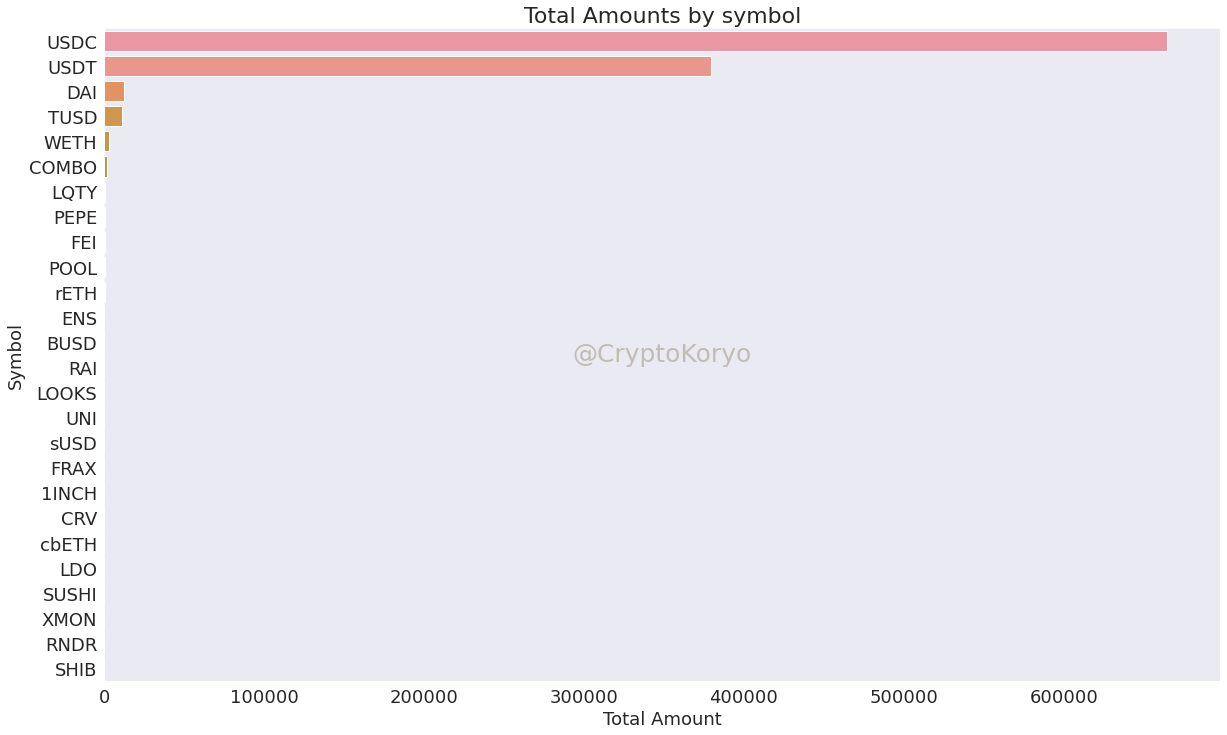

In [258]:
symbol_amounts = df.groupby('symbol')['usd_amount_received'].sum().reset_index()

# Sorting the symbol_amounts DataFrame by the 'Amount' column in descending order
symbol_amounts = symbol_amounts.sort_values('usd_amount_received', ascending=False)

# Plotting the bar plot using seaborn
plt.figure(figsize=(20, 12))  # Adjust the figure size as per your preference
sns.set_palette("Set3")  # Choose a color palette for the chart

# Plotting the bar plot
sns.barplot(x='usd_amount_received', y='symbol', data=symbol_amounts)

# Adding labels and title
plt.xlabel('Total Amount', fontsize=18)
plt.ylabel('Symbol', fontsize=18)
plt.title('Total Amounts by symbol', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Remove grid lines
plt.grid(False)

plt.text(0.5, 0.5, '@CryptoKoryo', horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=25, color='#c3bcb3')

ax.set_facecolor('#f4ece0')

# Displaying the chart
plt.savefig('plots/c1.png', dpi=400)
plt.show()


## Tokens used (number of occurences)

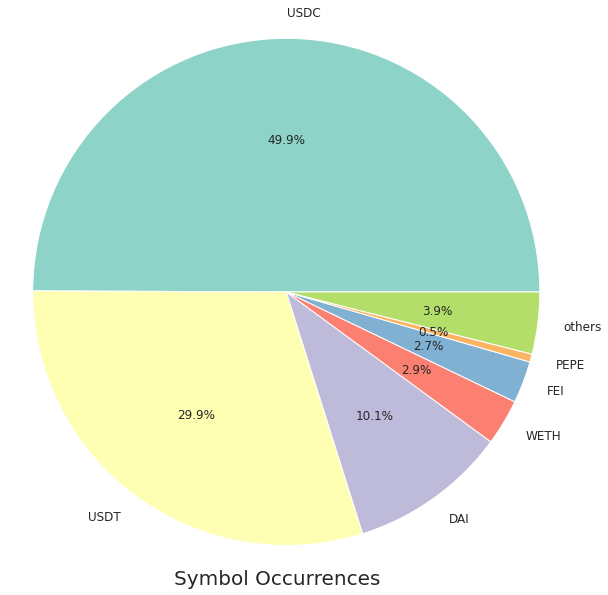

In [260]:
symbol_counts = df['symbol'].value_counts()

# Calculate the percentage of each symbol allocation
total_count = len(df['symbol'])
symbol_percentages = symbol_counts / total_count * 100

# Filter symbols with allocation below 1%
filtered_symbols = symbol_percentages[symbol_percentages >= 0.3]

# Group symbols below 1% as 'others'
others_count = symbol_percentages[symbol_percentages < 1].sum()
filtered_symbols['others'] = others_count

# Plotting the pie chart using seaborn
plt.figure(figsize=(10, 10))  # Adjust the figure size as per your preference
sns.set_palette("Set3")  # Choose a color palette for the chart

# Plotting the pie chart
plt.pie(filtered_symbols, labels=filtered_symbols.index, autopct='%2.1f%%', textprops={'fontsize': 12})
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

# Adding a title
plt.suptitle('Symbol Occurrences', fontsize=20, y=0.12)

# Displaying the chart
plt.savefig('plots/c2.png',bbox_inches='tight', dpi=400)

plt.show()


## Stats by cohorts

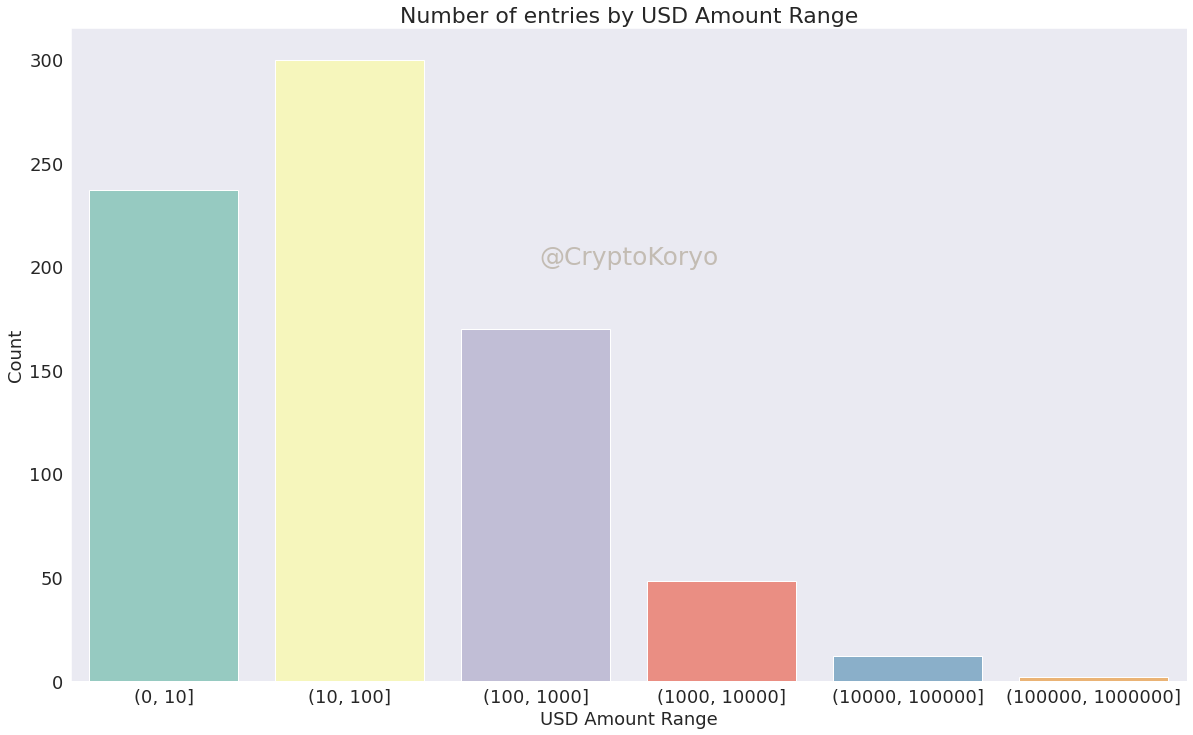

In [262]:
usd_amounts = df['usd_amount_received']

# Define the amount ranges
amount_ranges = [0, 10, 100, 1000, 10000, 100000, 1000000]

# Cut the data into the defined ranges and count the occurrences
amount_counts = pd.cut(usd_amounts, bins=amount_ranges).value_counts().sort_index()

# Plotting the bar plot using seaborn
plt.figure(figsize=(20, 12))  # Adjust the figure size as per your preference

# Plotting the bar plot
sns.barplot(x=amount_counts.index.astype(str), y=amount_counts)

# Adding labels and title
plt.xlabel('USD Amount Range', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Number of entries by USD Amount Range', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Remove grid lines
plt.grid(False)

plt.text(0.5, 0.65, '@CryptoKoryo', horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=25, color='#c3bcb3')
ax.set_facecolor('#f4ece0')

plt.savefig('plots/c3.png',bbox_inches='tight', dpi=400)


# Displaying the chart
plt.show()


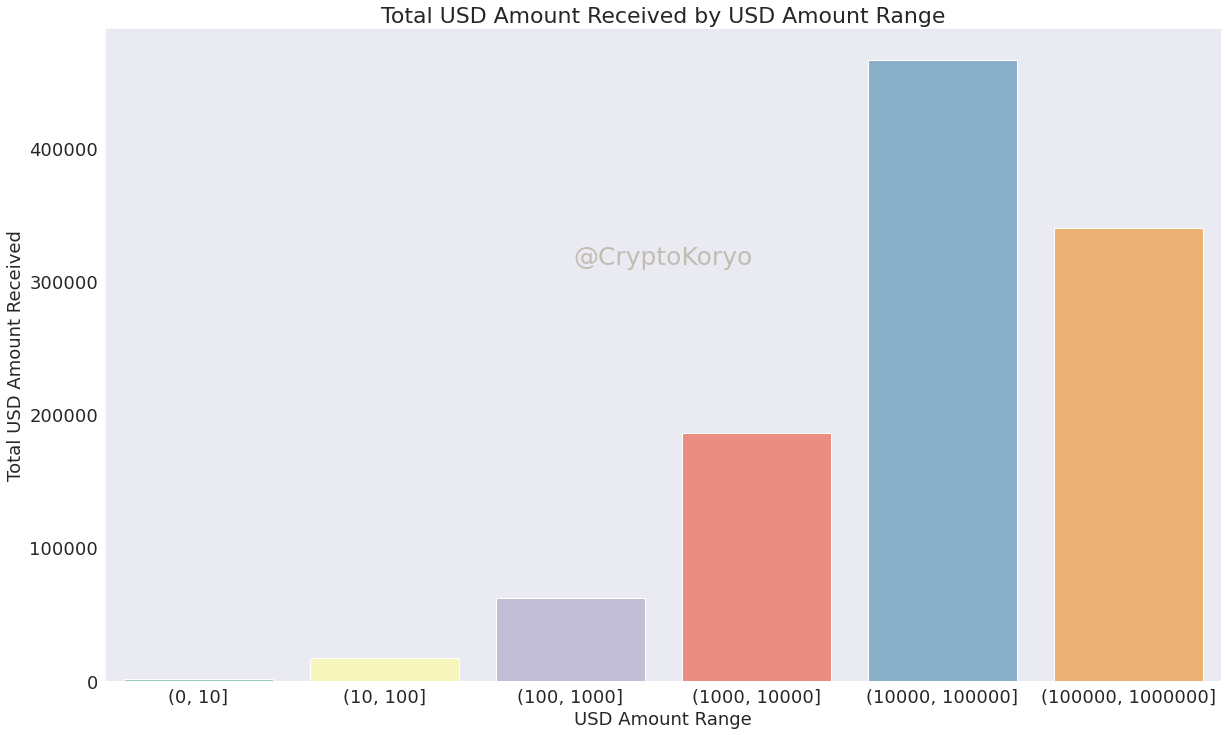

In [263]:
usd_amounts = df['usd_amount_received']

# Define the amount ranges
amount_ranges = [0, 10, 100, 1000, 10000, 100000, 1000000]


amount_sums = usd_amounts.groupby(pd.cut(usd_amounts, bins=amount_ranges)).sum().dropna()

# Plotting the bar plot using seaborn
plt.figure(figsize=(20, 12))  # Adjust the figure size as per your preference

# Plotting the bar plot
sns.barplot(x=amount_sums.index.astype(str), y=amount_sums)

# Adding labels and title
plt.xlabel('USD Amount Range', fontsize=18)
plt.ylabel('Total USD Amount Received', fontsize=18)
plt.title('Total USD Amount Received by USD Amount Range', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Remove grid lines
plt.grid(False)

plt.text(0.5, 0.65, '@CryptoKoryo', horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=25, color='#c3bcb3')
ax.set_facecolor('#f4ece0')

plt.savefig('plots/c4.png',bbox_inches='tight', dpi=400)
# Displaying the chart
plt.show()


In [171]:
amount_sums

usd_amount_received
(0, 10]                1125.0
(10, 100]             16911.0
(100, 1000]           61991.0
(1000, 10000]        186063.0
(10000, 100000]      466857.0
(100000, 1000000]    340544.0
Name: usd_amount_received, dtype: float64

In [216]:
print(f'There were around {amount_counts.sum()} payments. Hee ae the details of occurences for each bin:')
amount_counts

There were around 769 payments. Hee ae the details of occurences for each bin:


(0, 10]              237
(10, 100]            300
(100, 1000]          170
(1000, 10000]         48
(10000, 100000]       12
(100000, 1000000]      2
Name: usd_amount_received, dtype: int64

## Contribution by whales and shrimps

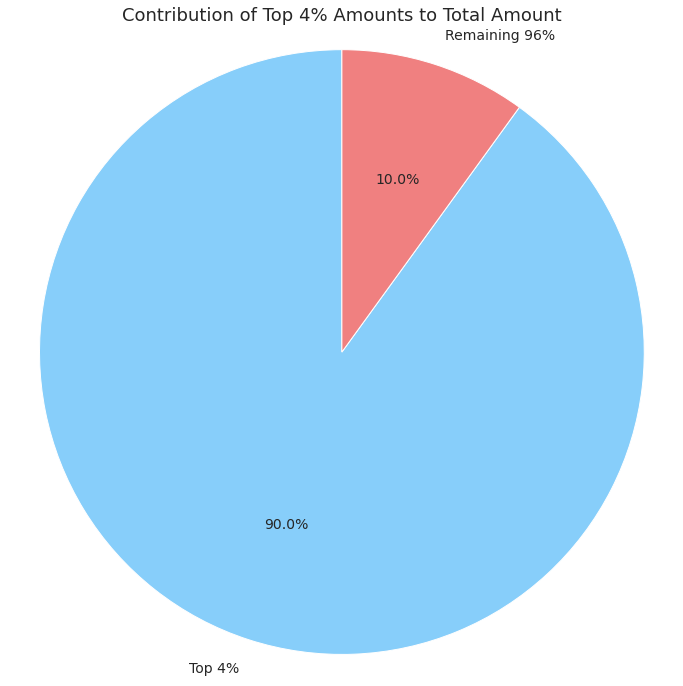

In [264]:
usd_amounts = df['usd_amount_received']

# Calculate the total amount
total_amount = usd_amounts.sum()

# Sort the amounts in descending order
sorted_amounts = usd_amounts.sort_values(ascending=False)

# Calculate the cutoff for the top 4% amounts
cutoff_index = int(len(sorted_amounts) * 0.04)

# Select the top 4% amounts
top_4_amounts = sorted_amounts[:cutoff_index]

# Calculate the contribution of the top 4% amounts to the total amount
top_4_contribution = top_4_amounts.sum() / total_amount * 100

# Calculate the remaining 96% contribution
remaining_contribution = 100 - top_4_contribution

# Plotting the contribution using a pie chart
plt.figure(figsize=(12, 12)) 

# Plotting the pie chart
plt.pie([top_4_contribution, remaining_contribution], labels=['Top 4%', 'Remaining 96%'],
        autopct='%1.1f%%', startangle=90, colors=['lightskyblue', 'lightcoral'], textprops={'fontsize': 14})
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

# Adding a title
plt.title('Contribution of Top 4% Amounts to Total Amount', fontsize=18)

plt.savefig('plots/c5.png',bbox_inches='tight', dpi=400)
# Displaying the chart
plt.show()


## Cumulative USD Amount Received Over Time

In [181]:
df['evt_block_time'] = pd.to_datetime(df['evt_block_time'], format='%Y-%m-%d %H:%M:%S.%f %Z', errors='coerce')
df.sort_values('evt_block_time', inplace=True)
df['cumulative_usd_amount'] = df['usd_amount_received'].cumsum()

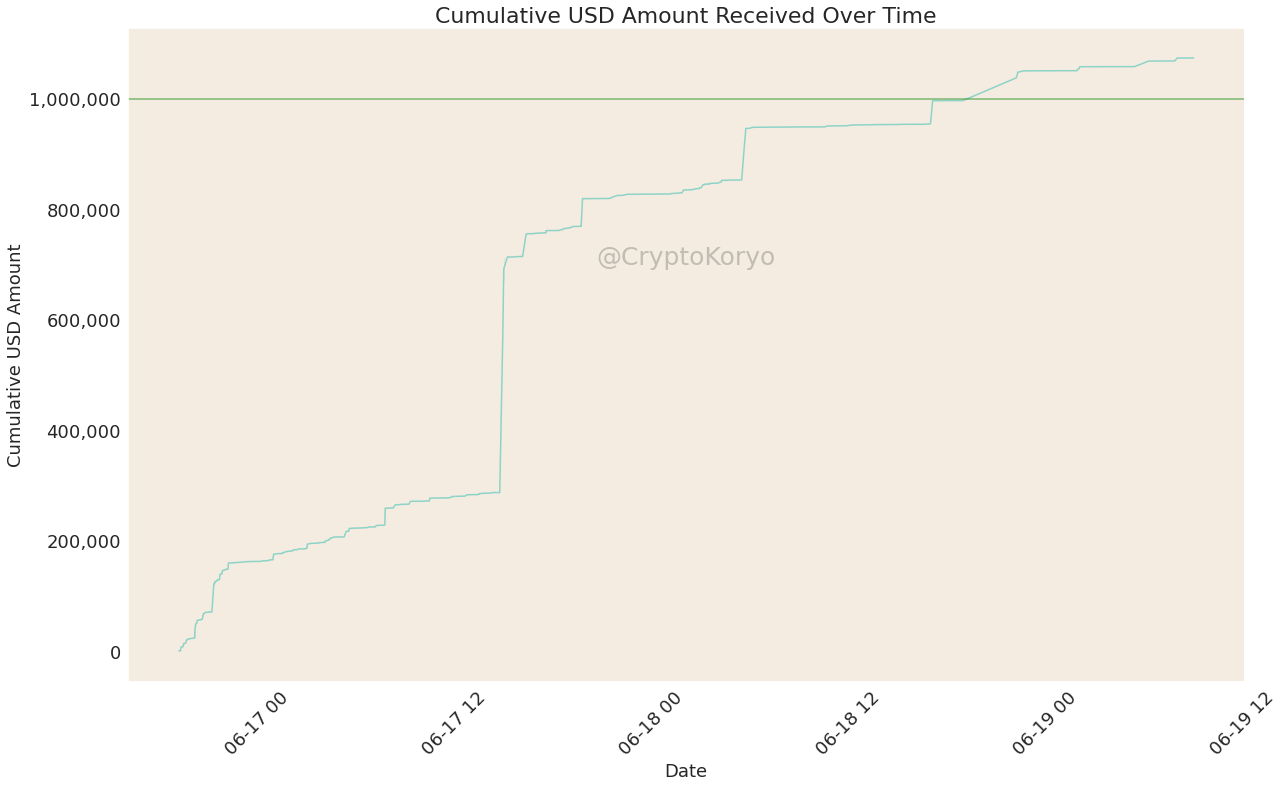

In [265]:
plt.figure(figsize=(20, 12))
ax = sns.lineplot(x=df['evt_block_time'], y=df['cumulative_usd_amount'])

# Set labels and title
plt.xlabel('Date', fontsize=18)
plt.ylabel('Cumulative USD Amount', fontsize=18)
# Increase tick label size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title('Cumulative USD Amount Received Over Time', fontsize=22)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Remove grid lines
plt.grid(b=None)

plt.text(0.5, 0.65, '@CryptoKoryo', horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=25, color='#c3bcb3')

ax.set_facecolor('#f4ece0')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.axhline(y=1000000,alpha=0.5,color='g')

plt.savefig('/home/dl/dev/CryptoKoryoGithub/Web3Lab/data/c6.png',bbox_inches='tight', dpi=400)
# Display the plot
plt.show()
